In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading Data
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


Text(0.5, 0, 'Date')

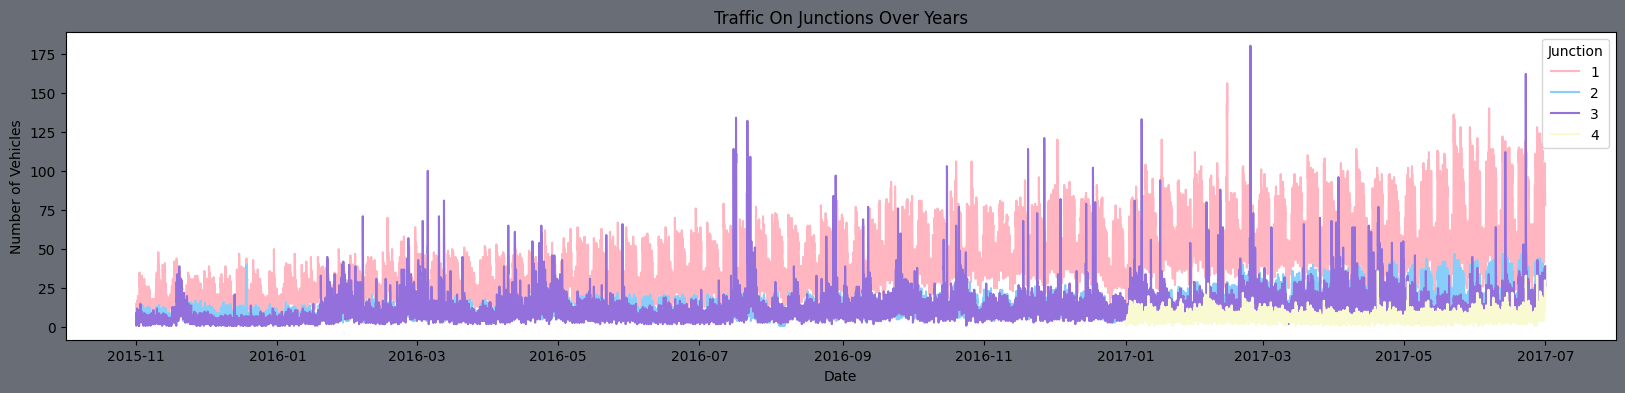

In [ ]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = ["#FFB6C1", "#87CEFA", "#9370DB", "#FAFAD2"]
plt.figure(figsize=(20,4),facecolor="#686D76")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")


In [ ]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


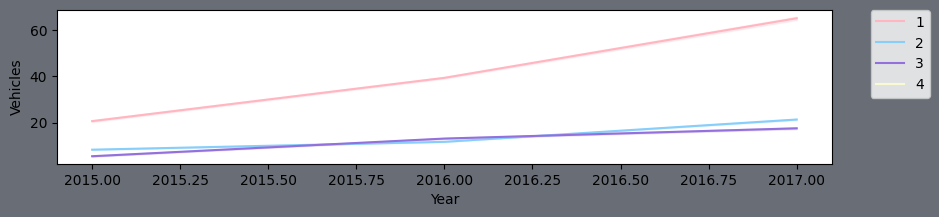

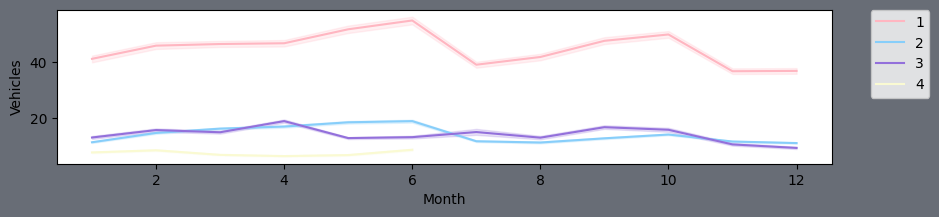

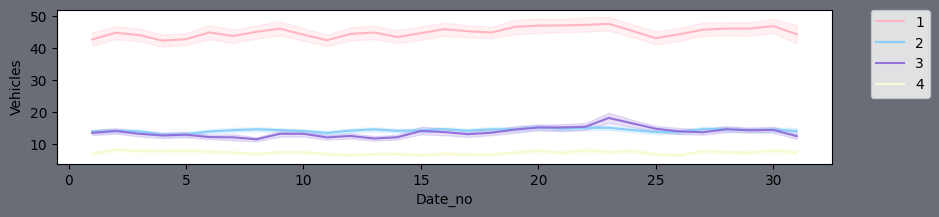

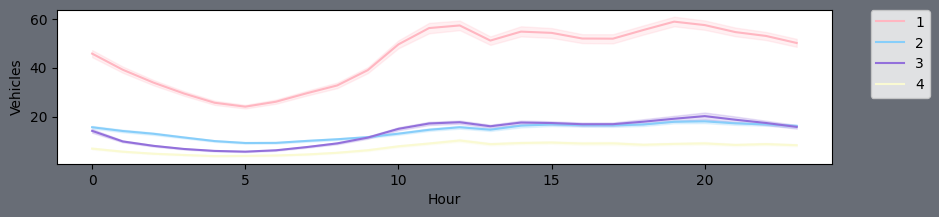

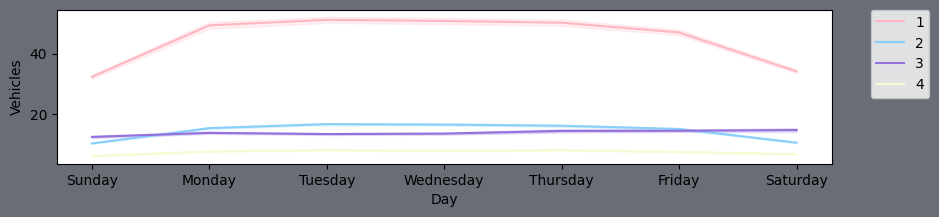

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#686D76")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
#Pivoting data from junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.head()

Vehicles              
Junction                   1    2    3   4
DateTime                                  
2015-11-01 00:00:00     15.0  6.0  9.0 NaN
2015-11-01 01:00:00     13.0  6.0  7.0 NaN
2015-11-01 02:00:00     10.0  5.0  5.0 NaN
2015-11-01 03:00:00      7.0  6.0  1.0 NaN
2015-11-01 04:00:00      9.0  7.0  2.0 NaN

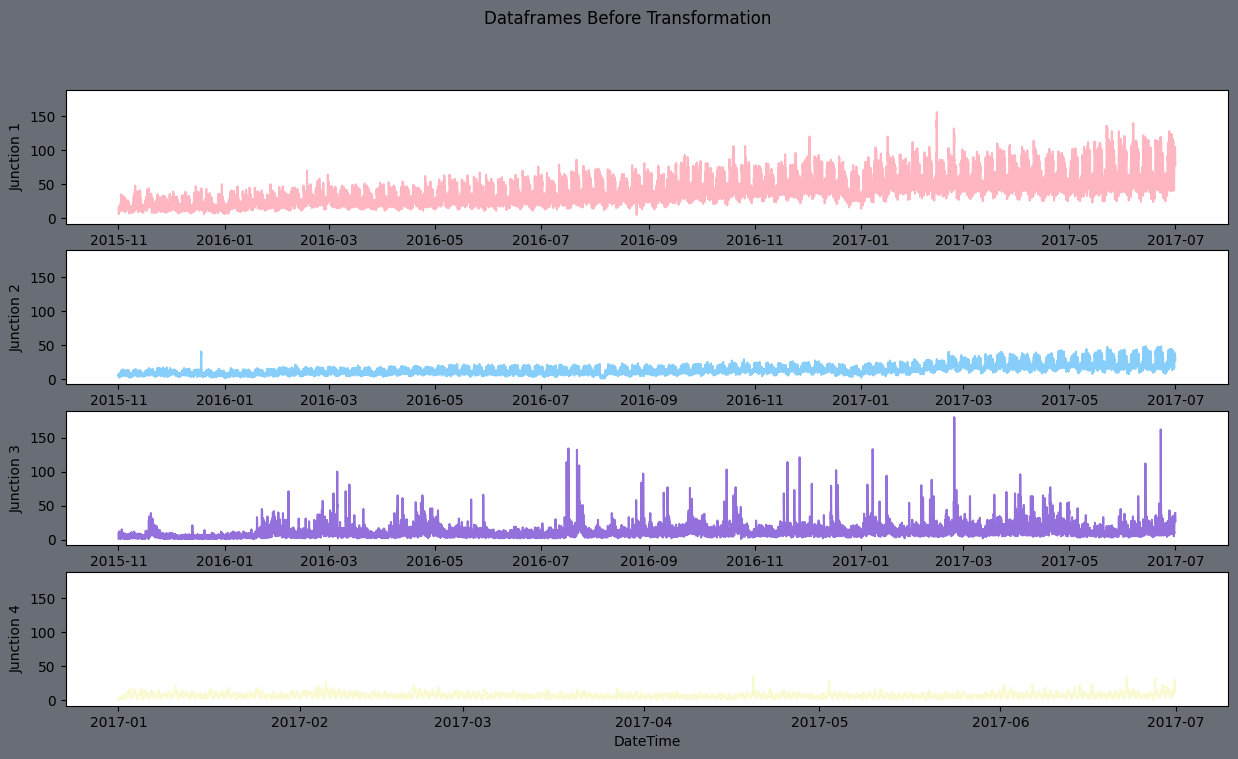

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#686D76", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

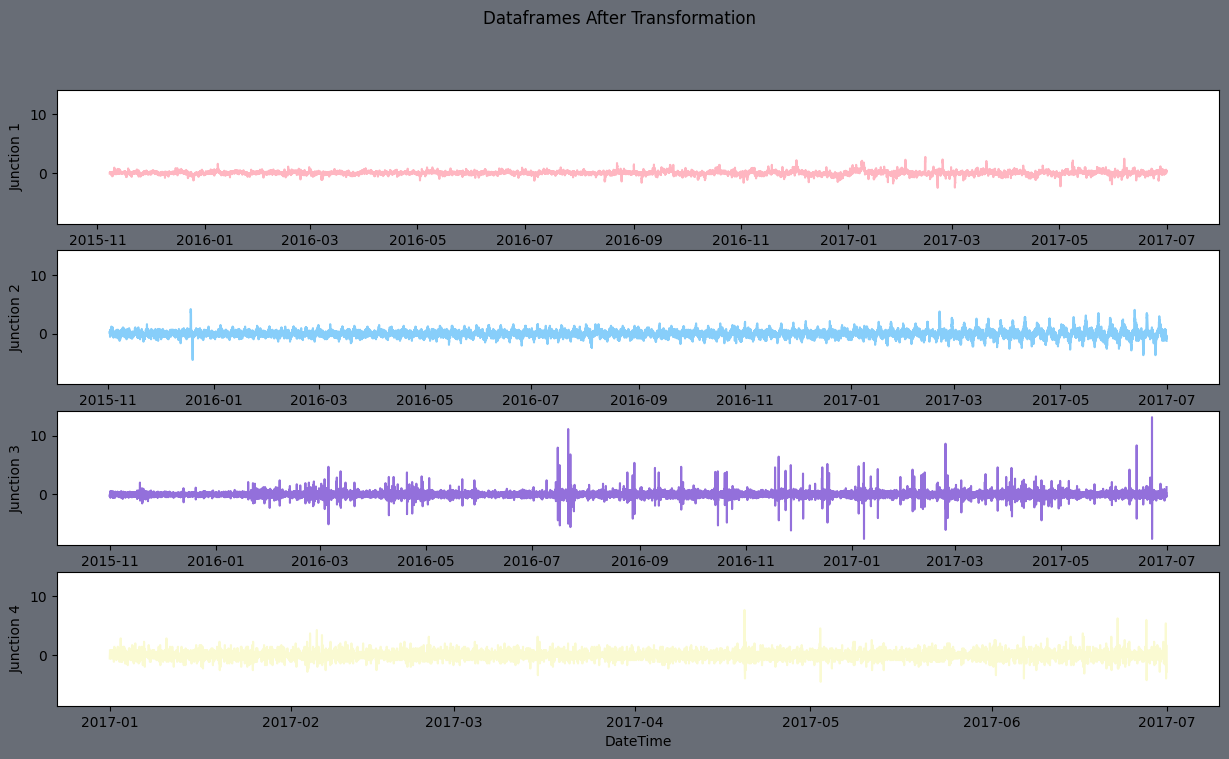

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
X_trainJ1.shape

(12949, 32, 1)

In [ ]:
# Custom Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

# Custom_Model for the prediction
def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(layers.Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2])))  # Flatten layer
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(CustomLayer(50))  # Custom layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_Custom = model.predict(X_Test)
    return pred_Custom

#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning.

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

# MLP Model for the prediction
def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#686D76")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ1_Custom = Custom_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ1_MLP = MLP_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
108/108 [==============================] - 4s 5ms/step - loss: 0.0701 - val_loss: 0.0710
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0576 - val_loss: 0.0671
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0548 - val_loss: 0.0622
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0526 - val_loss: 0.0611
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0516 - val_loss: 0.0600
Epoch 6/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0595
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0499 - val_loss: 0.0594
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.0592
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0486 - val_loss: 0.0589
Epoch 10/50
108/108 [==============================] - 1s 6

########------Custom Model------########
The root mean squared error is 0.24000262483489623.


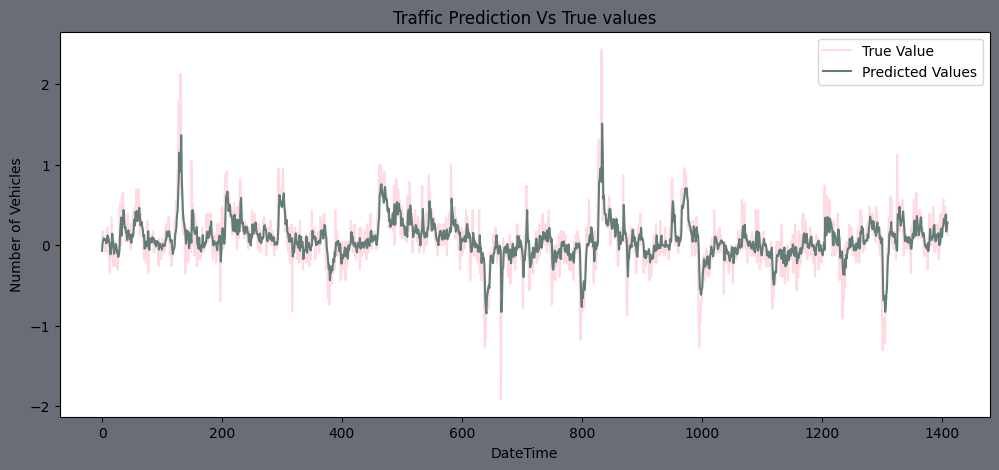

########------GRU Model------########
The root mean squared error is 0.24911337324488592.


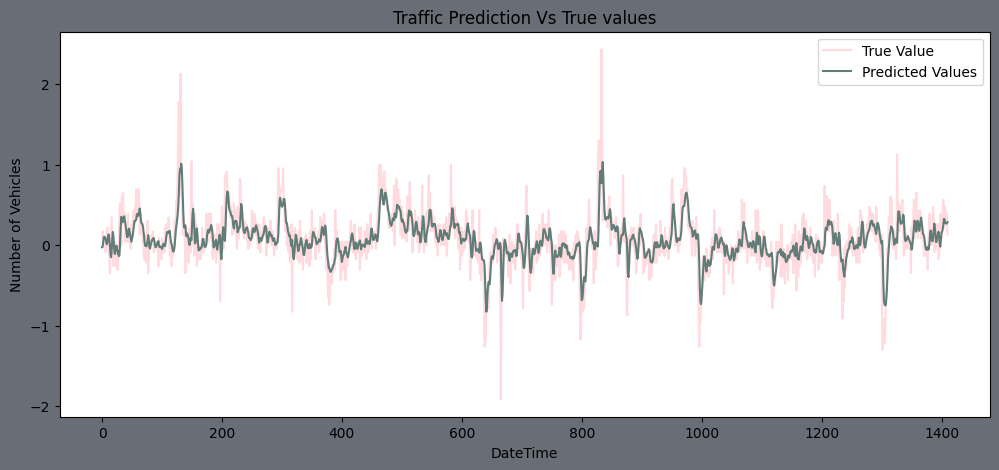


########------LSTM Model------########
The root mean squared error is 0.2752706183464816.


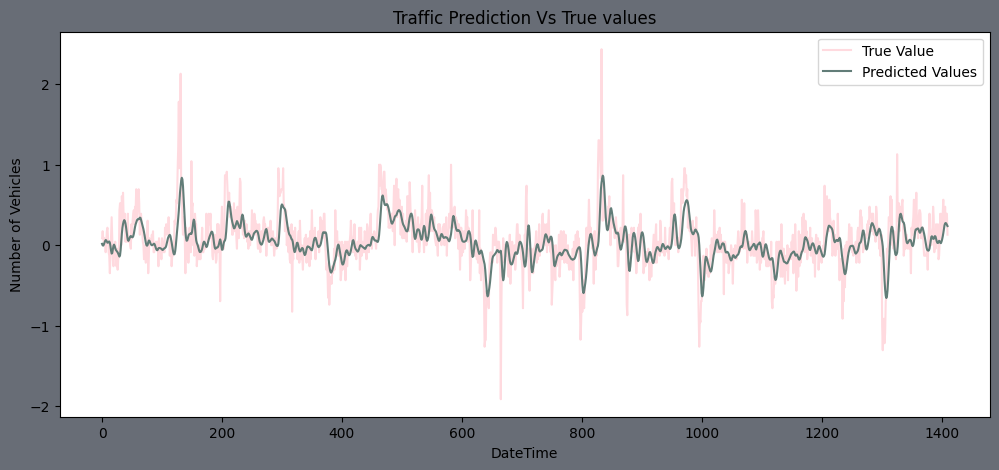


########------CNN Model------########
The root mean squared error is 0.24819709834159645.


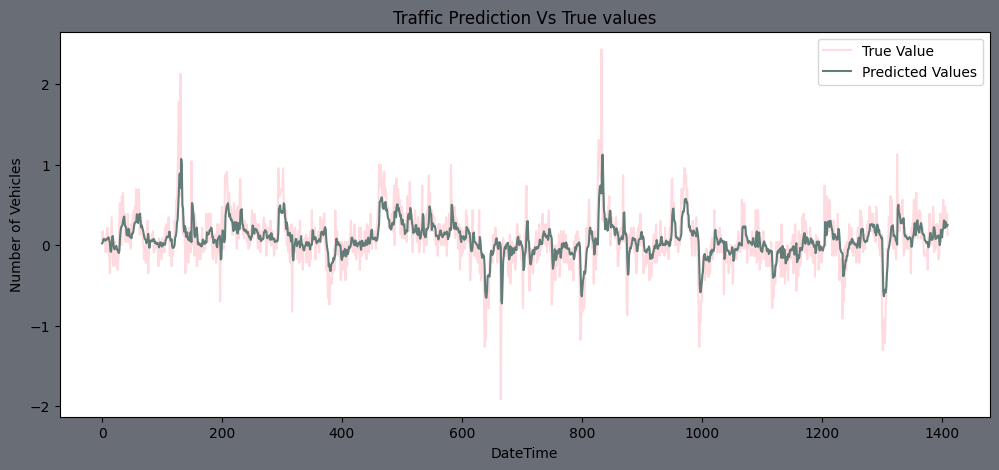


########------MLP Model------########
The root mean squared error is 0.24584038477871542.


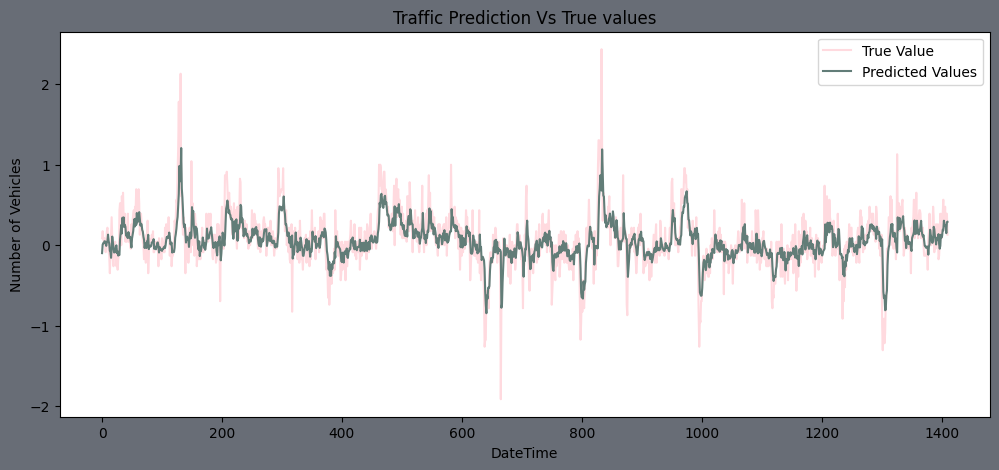


Best Model: Custom - RMSE: 0.24000262483489623



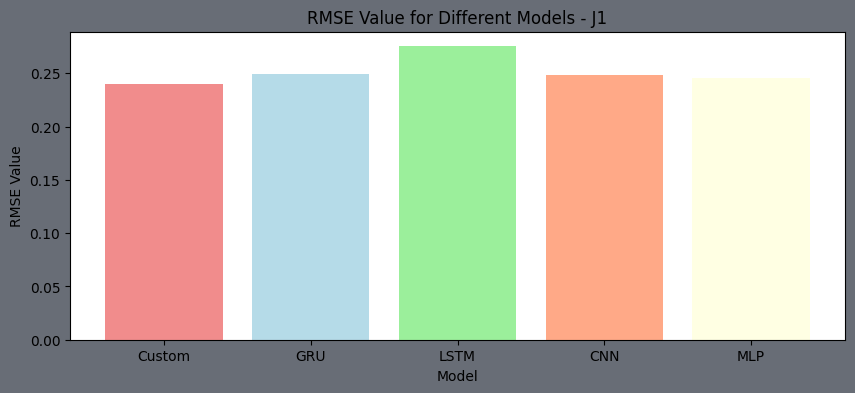

,MODEL,RMSE
0,Custom,0.240003
1,GRU,0.249113
2,LSTM,0.275271
3,CNN,0.248197
4,MLP,0.245840


In [ ]:
# Results for J1 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J1_Custom = RMSE_Value(y_testJ1, PredJ1_Custom)
PredictionsPlot(y_testJ1, PredJ1_Custom, 0)

# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)

# Results for J1 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

# Results for J1 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J1_Custom, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_1, best_model_rmse_1))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4),facecolor="#686D76")  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J1')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Second Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ2_Custom = Custom_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
109/109 [==============================] - 1s 5ms/step - loss: 0.2209 - val_loss: 0.3175
Epoch 2/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1736 - val_loss: 0.2634
Epoch 3/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1625 - val_loss: 0.2494
Epoch 4/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1555 - val_loss: 0.2434
Epoch 5/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1511 - val_loss: 0.2412
Epoch 6/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1497 - val_loss: 0.2511
Epoch 7/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1485 - val_loss: 0.2473
Epoch 8/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1464 - val_loss: 0.2320
Epoch 9/50
109/109 [==============================] - 1s 5ms/step - loss: 0.1448 - val_loss: 0.2235
Epoch 10/50
109/109 [==============================] - 1s 5

########------Custom Model------########
The root mean squared error is 0.47274228315273104.


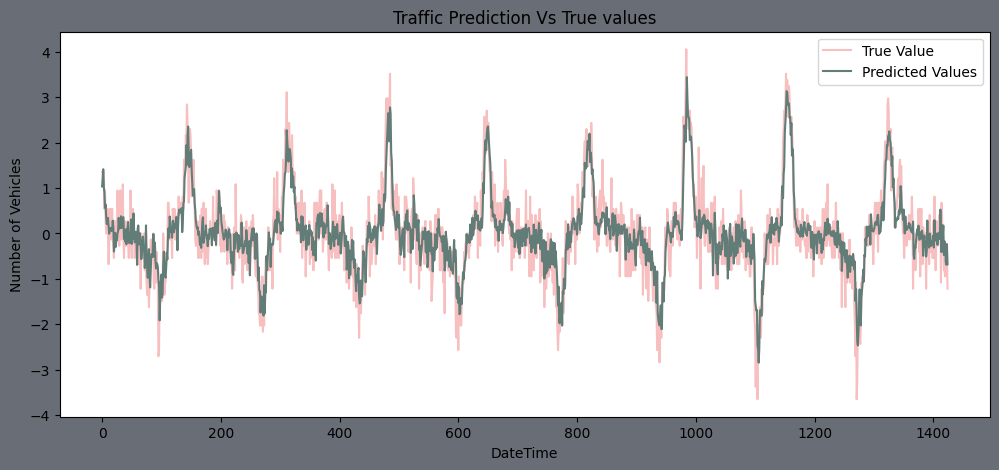

########------GRU Model------########
The root mean squared error is 0.5618751891182838.


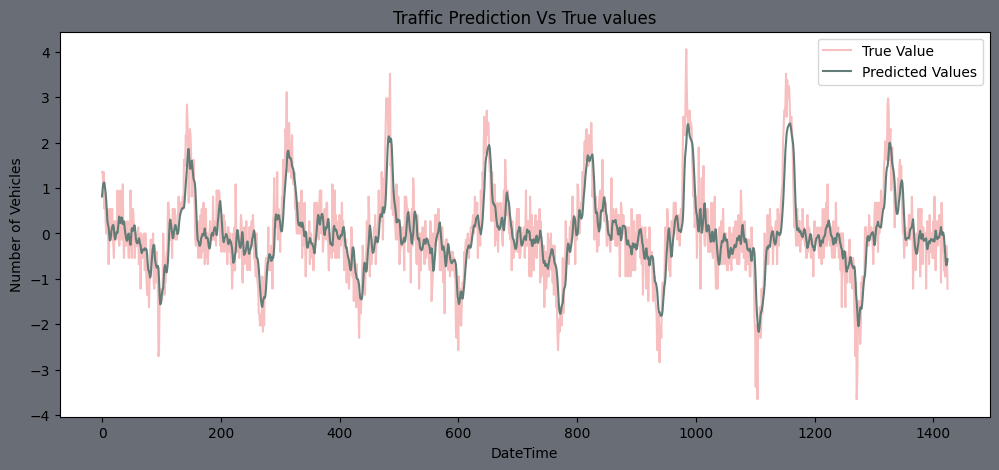


########------LSTM Model------########
The root mean squared error is 0.5773453896336966.


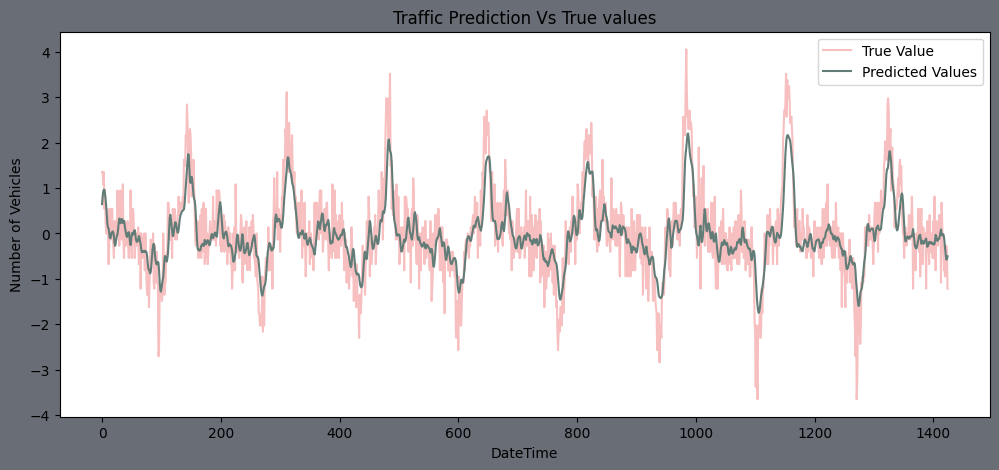


########------CNN Model------########
The root mean squared error is 0.5369537776244403.


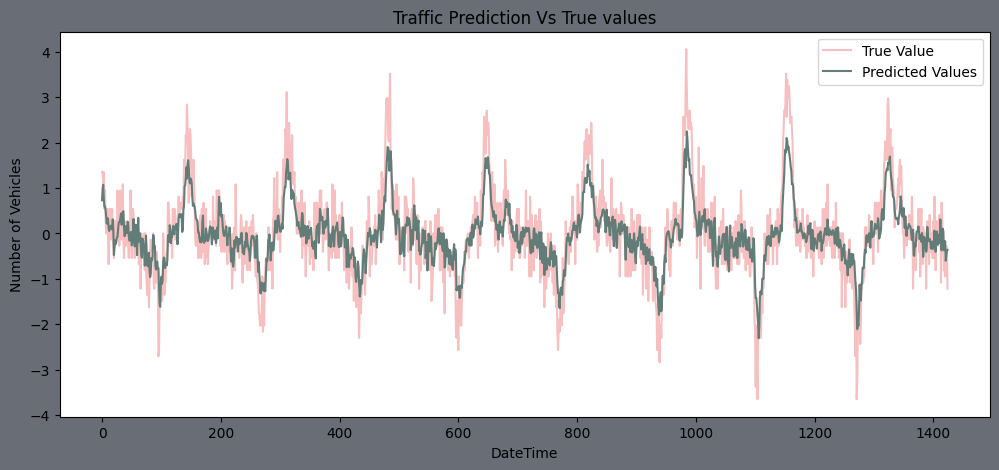


########------MLP Model------########
The root mean squared error is 0.5366766386178962.


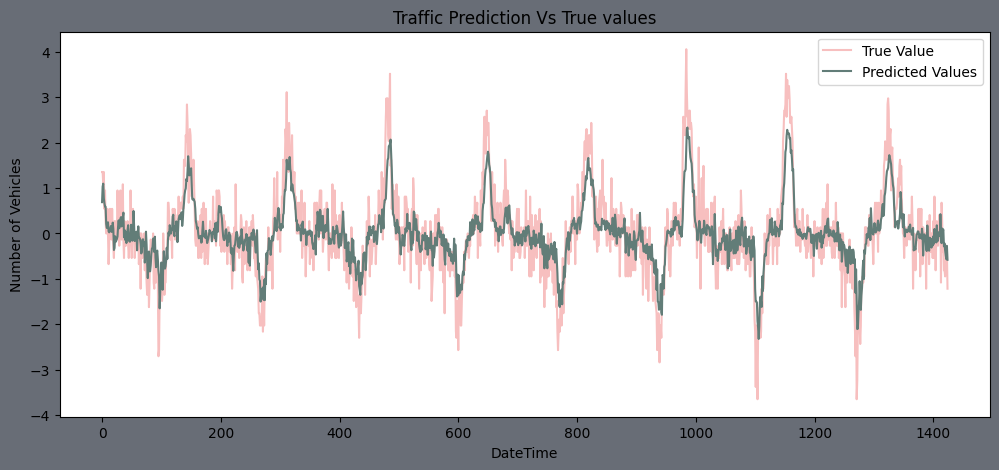


Best Model: Custom - RMSE: 0.47274228315273104



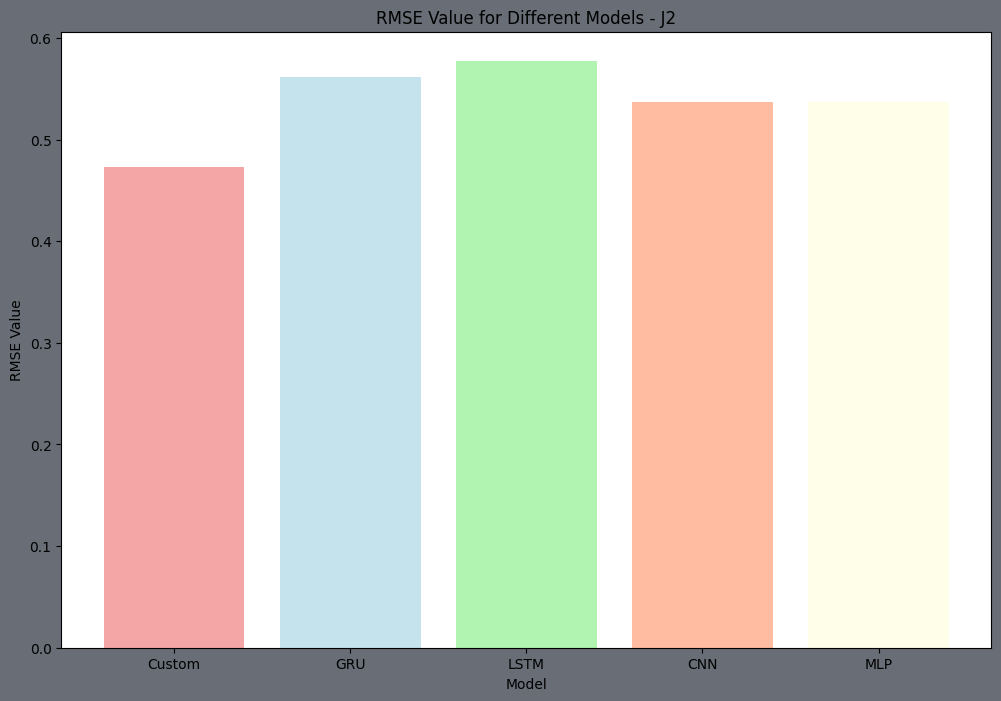

,MODEL,RMSE
0,Custom,0.472742
1,GRU,0.561875
2,LSTM,0.577345
3,CNN,0.536954
4,MLP,0.536677


In [ ]:
# Results for J2 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J2_Custom = RMSE_Value(y_testJ2, PredJ2_Custom)
PredictionsPlot(y_testJ2, PredJ2_Custom, 0)

# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)

# Results for J2 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)

# Results for J2 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J2_Custom, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_2, best_model_rmse_2))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8),facecolor="#686D76")  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J2')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Third Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ3_Custom = Custom_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ3_LSTM = LSTM_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
110/110 [==============================] - 1s 5ms/step - loss: 0.2971 - val_loss: 0.3635
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2753 - val_loss: 0.3498
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2703 - val_loss: 0.3669
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2662 - val_loss: 0.3375
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2579 - val_loss: 0.3418
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2529 - val_loss: 0.3412
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2498 - val_loss: 0.3441
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2507 - val_loss: 0.3484
Epoch 9/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2427 - val_loss: 0.3491
Epoch 10/50
110/110 [==============================] - 0s 4

########------Custom Model------########
The root mean squared error is 0.5550704904096121.


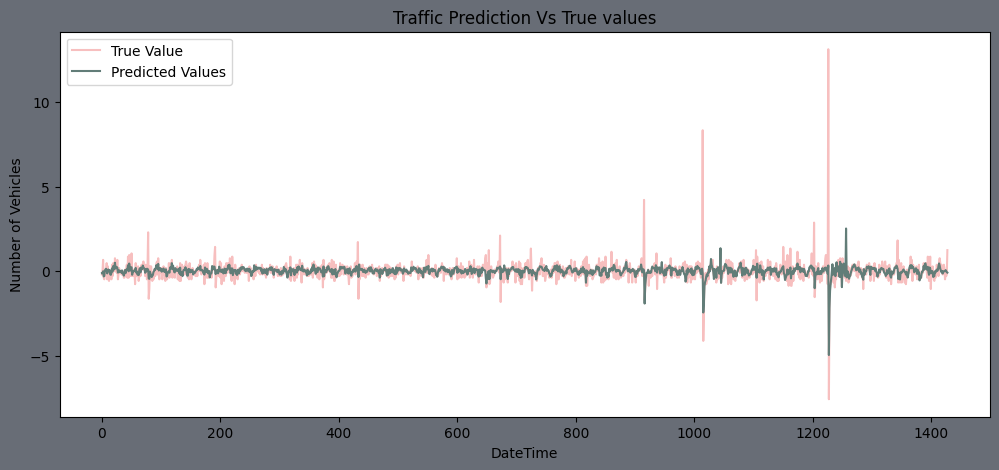

########------GRU Model------########
The root mean squared error is 0.6087773968779681.


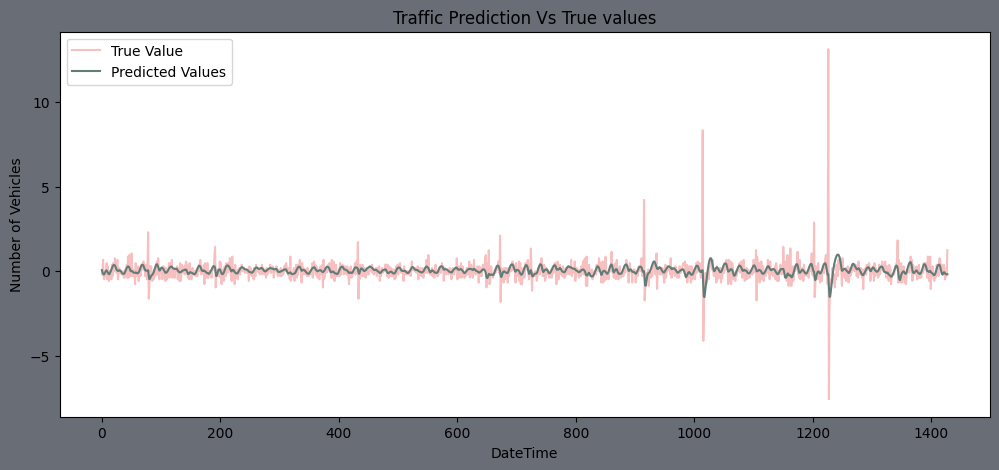


########------LSTM Model------########
The root mean squared error is 0.6202839566363246.


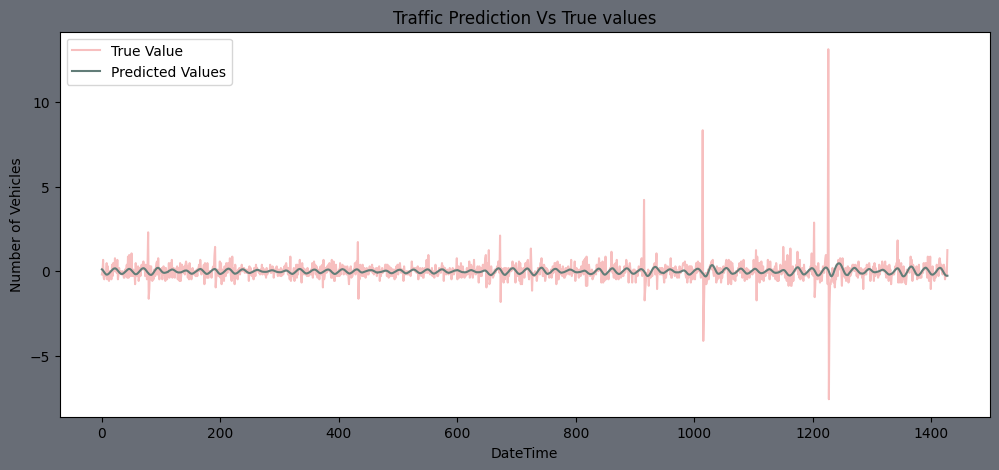


########------CNN Model------########
The root mean squared error is 0.5747578568431735.


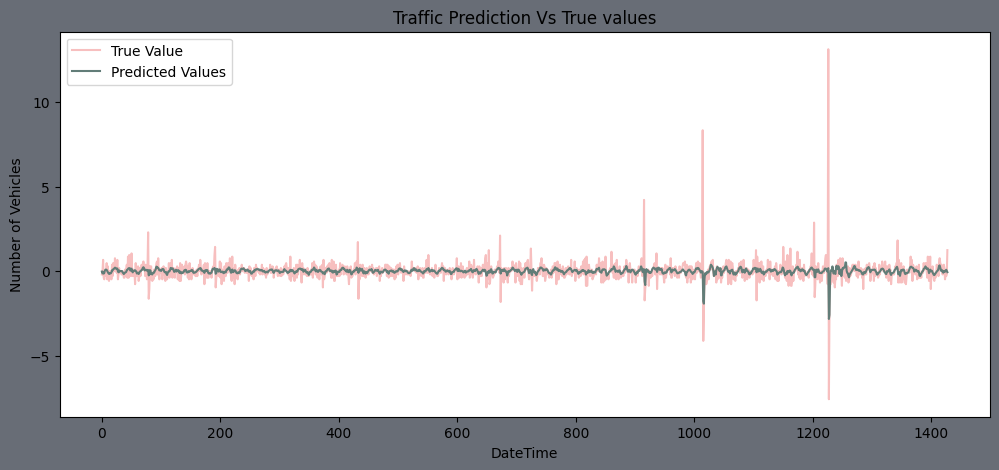


########------MLP Model------########
The root mean squared error is 0.6250607111381954.


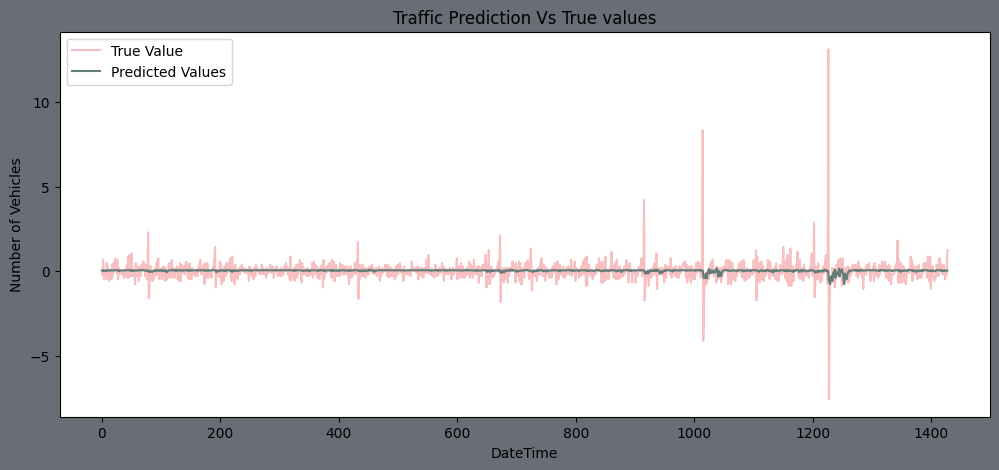


Best Model: Custom - RMSE: 0.5550704904096121



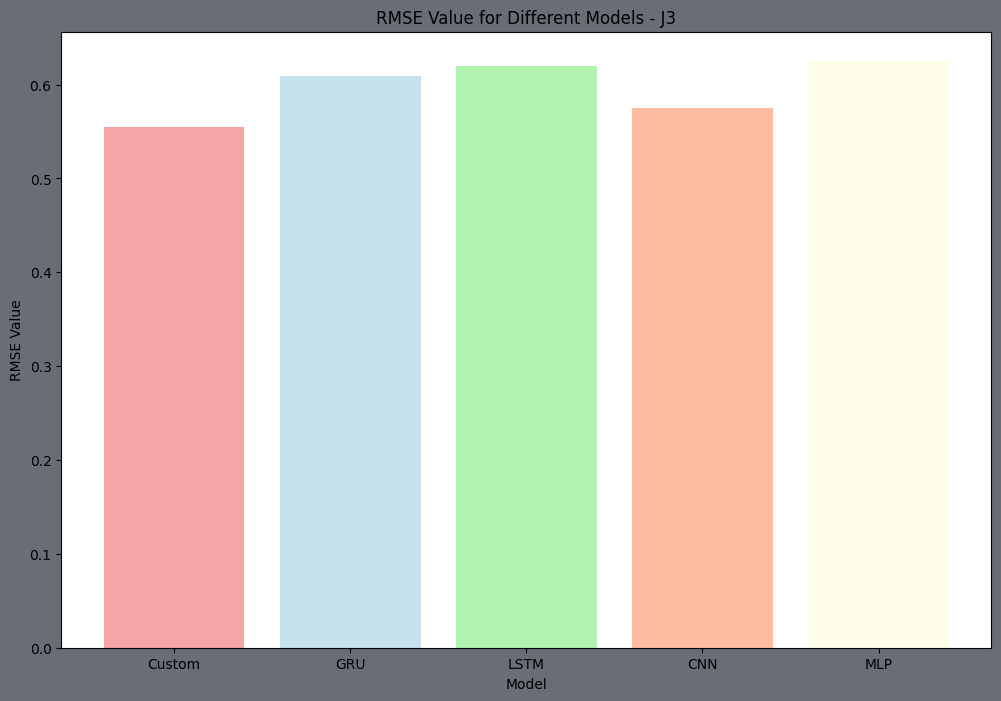

,MODEL,RMSE
0,Custom,0.555070
1,GRU,0.608777
2,LSTM,0.620284
3,CNN,0.574758
4,MLP,0.625061


In [ ]:
# Results for J3 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J3_Custom = RMSE_Value(y_testJ3, PredJ3_Custom)
PredictionsPlot(y_testJ3, PredJ3_Custom, 0)

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J3_LSTM = RMSE_Value(y_testJ3, PredJ3_LSTM)
PredictionsPlot(y_testJ3, PredJ3_LSTM, 0)

# Results for J3 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)

# Results for J3 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
PredictionsPlot(y_testJ3, PredJ3_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J3_Custom, RMSE_J3_GRU, RMSE_J3_LSTM, RMSE_J3_CNN, RMSE_J3_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_3, best_model_rmse_3))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8),facecolor="#686D76")  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J3')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ4_Custom = Custom_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ4_LSTM = LSTM_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
33/33 [==============================] - 1s 9ms/step - loss: 0.6878 - val_loss: 1.1774
Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 0.6291 - val_loss: 1.0829
Epoch 3/50
33/33 [==============================] - 0s 5ms/step - loss: 0.6019 - val_loss: 1.0812
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5724 - val_loss: 1.0489
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5564 - val_loss: 1.0480
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.5459 - val_loss: 1.0531
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.5336 - val_loss: 1.0450
Epoch 8/50
33/33 [==============================] - 0s 6ms/step - loss: 0.5226 - val_loss: 1.0362
Epoch 9/50
33/33 [==============================] - 0s 6ms/step - loss: 0.5193 - val_loss: 1.0268
Epoch 10/50
33/33 [==============================] - 0s 6ms/step - loss: 0.49

########------Custom Model------########
The root mean squared error is 1.0099669188238225.


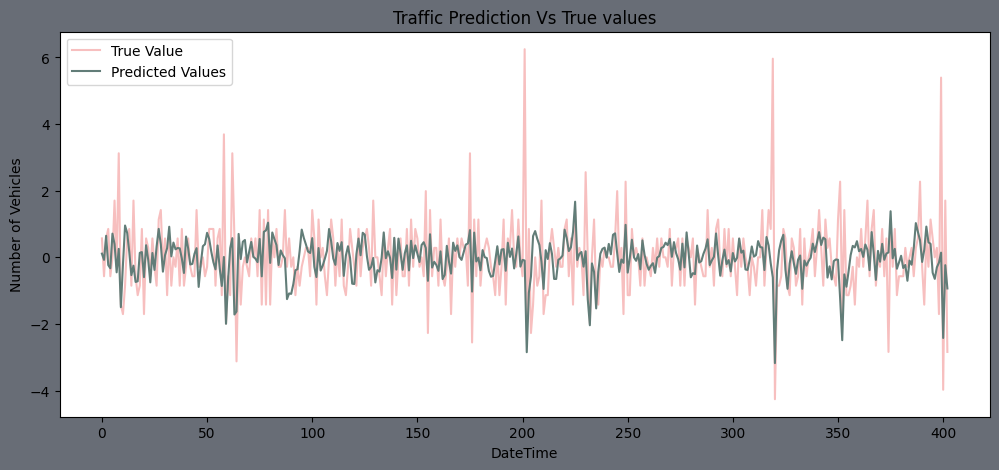

########------GRU Model------########
The root mean squared error is 0.9964836434919706.


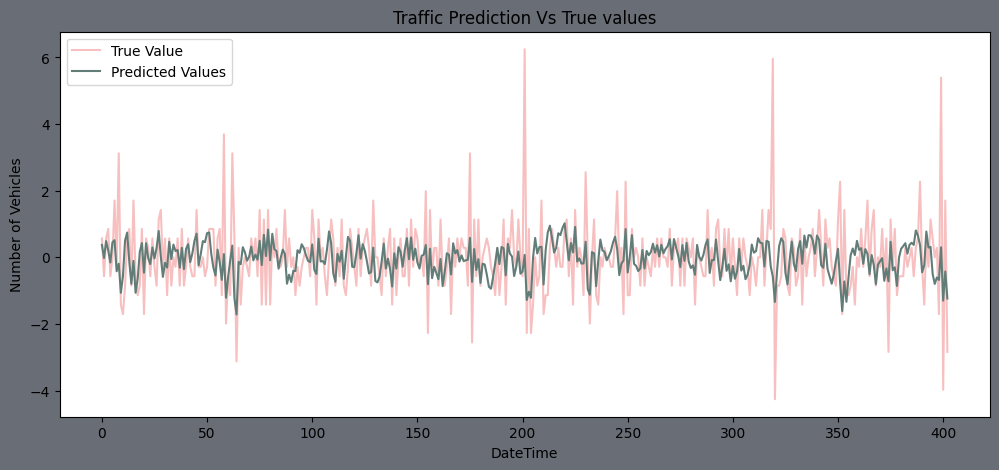


########------LSTM Model------########
The root mean squared error is 1.0959713876142005.


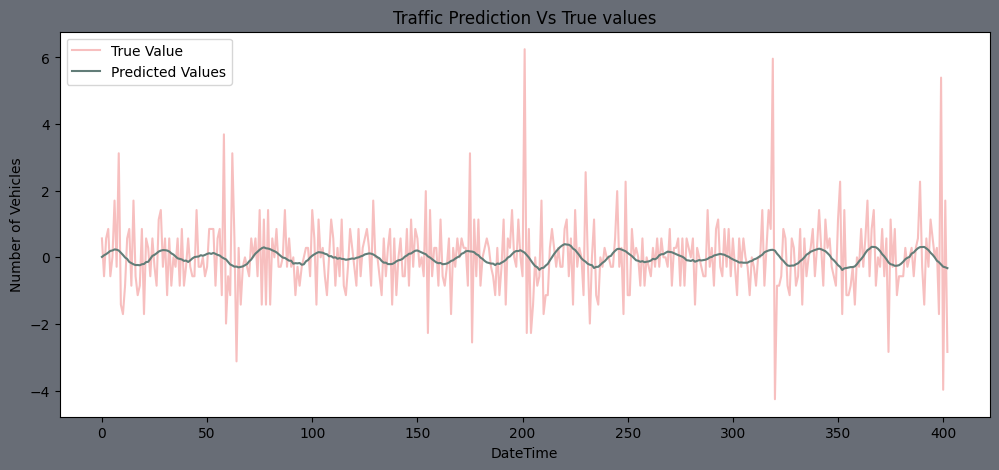


########------CNN Model------########
The root mean squared error is 1.0005284393141216.


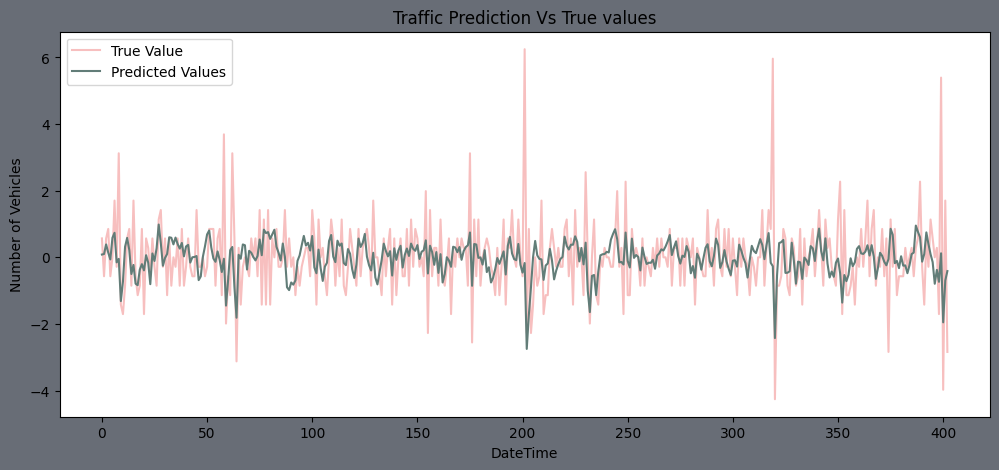


########------MLP Model------########
The root mean squared error is 1.1150421299717725.


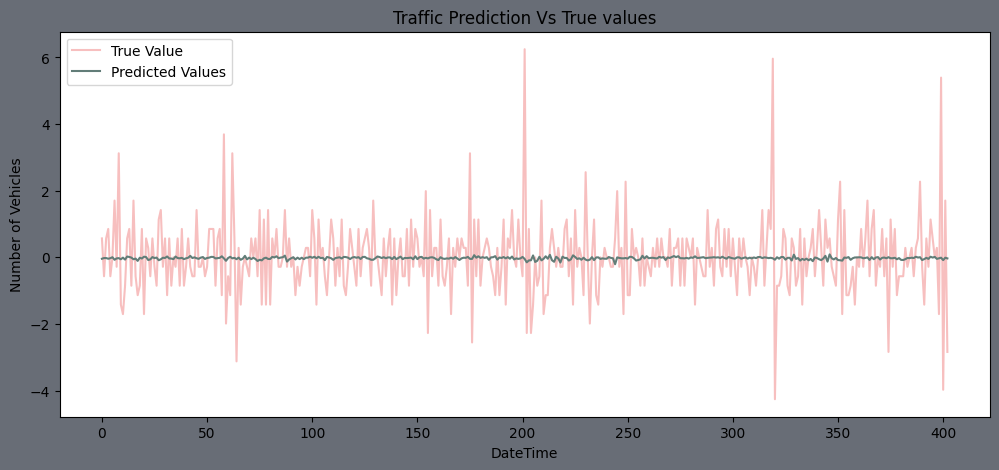


Best Model: GRU - RMSE: 0.9964836434919706



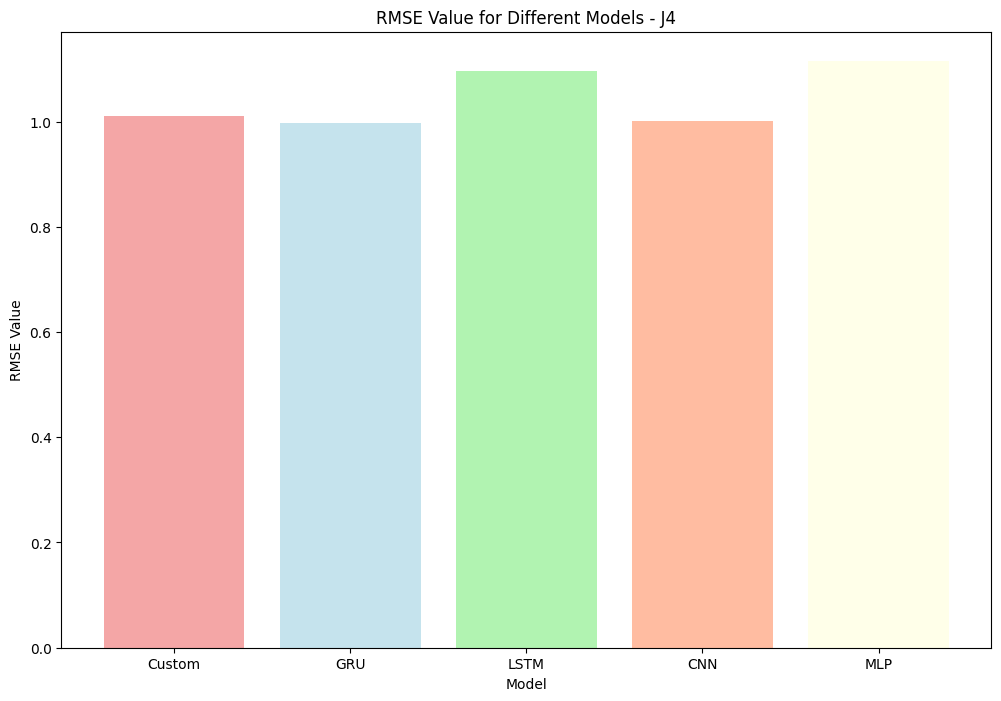

,MODEL,RMSE
0,Custom,1.009967
1,GRU,0.996484
2,LSTM,1.095971
3,CNN,1.000528
4,MLP,1.115042


In [ ]:
# Results for J4 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J4_Custom = RMSE_Value(y_testJ4, PredJ4_Custom)
PredictionsPlot(y_testJ4, PredJ4_Custom, 0)

# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J4_LSTM = RMSE_Value(y_testJ4, PredJ4_LSTM)
PredictionsPlot(y_testJ4, PredJ4_LSTM, 0)

# Results for J4 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)

# Results for J4 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
PredictionsPlot(y_testJ4, PredJ4_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J4_Custom, RMSE_J4_GRU, RMSE_J4_LSTM, RMSE_J4_CNN, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_4, best_model_rmse_4))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J4')
plt.show()

display(styled_df)

In [ ]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE,MODEL
0,Junction1,0.240003,Custom
1,Junction2,0.472742,Custom
2,Junction3,0.555070,Custom
3,Junction4,0.996484,GRU
